# Using Python tools for a analysis of COVID-19 data

# ARIMA method to forecast

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product 
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
mpl.rcParams['font.size'] = 15.0

In [3]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

### <span style="color:red">Analysis of the last N days</span>

In [4]:
Ndays = '150days'

### <span style="color:red">Day range for matplotlib</span>

In [5]:
Ninterval = 7

In [6]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [7]:
#filename = '/home/davi/Documents/Python/Covid-19-Data/owid-covid-data.csv'

In [8]:
df = pd.read_csv(url)
# df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

In [9]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[df['date'] > pd.to_datetime("today") - pd.to_timedelta(Ndays)]
df = df.sort_values(by=['total_cases'], ascending=True)

# Number of cases and deaths in World

In [10]:
dfWorld = df[df['location'] == 'World']
dfWorld = dfWorld.sort_values(by='date', ascending=True)
dfWorld = dfWorld.loc[:,['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
dfWorld.reset_index(drop=True, inplace=True)
dfWorld.tail(15)

,date,total_cases,total_deaths,new_cases,new_deaths
135,2020-08-16,21472436.0,765990.0,259747.0,5656.0
136,2020-08-17,21704807.0,770213.0,232371.0,4223.0
137,2020-08-18,21901190.0,774471.0,196383.0,4258.0
138,2020-08-19,22156098.0,781152.0,254908.0,6681.0
139,2020-08-20,22437231.0,787685.0,281133.0,6533.0
140,2020-08-21,22713395.0,794027.0,276164.0,6342.0
141,2020-08-22,22967098.0,799939.0,253703.0,5912.0
142,2020-08-23,23233874.0,805573.0,266776.0,5634.0
143,2020-08-24,23458531.0,808896.0,224657.0,3323.0
144,2020-08-25,23669734.0,813147.0,211203.0,4251.0


In [11]:
ads = dfWorld.loc[:,['date','new_cases']]
ads = ads.set_index('date')
ads.tail(15)

,new_cases
date,
2020-08-16,259747.0
2020-08-17,232371.0
2020-08-18,196383.0
2020-08-19,254908.0
2020-08-20,281133.0
2020-08-21,276164.0
2020-08-22,253703.0
2020-08-23,266776.0
2020-08-24,224657.0


In [12]:
currency = dfWorld.loc[:,['date','new_deaths']]
currency = currency.set_index('date')
currency.tail(15)

,new_deaths
date,
2020-08-16,5656.0
2020-08-17,4223.0
2020-08-18,4258.0
2020-08-19,6681.0
2020-08-20,6533.0
2020-08-21,6342.0
2020-08-22,5912.0
2020-08-23,5634.0
2020-08-24,3323.0


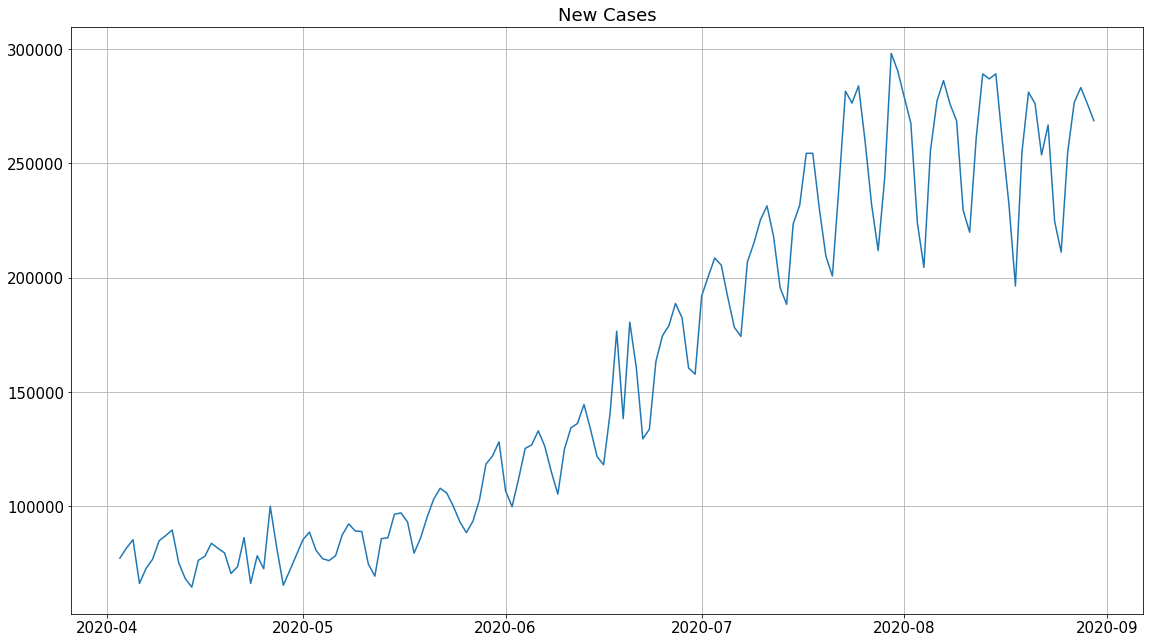

In [13]:
plt.figure(figsize=(19.20,10.80))
plt.plot(ads.new_cases)
plt.title('New Cases')
plt.grid(True)
plt.show()

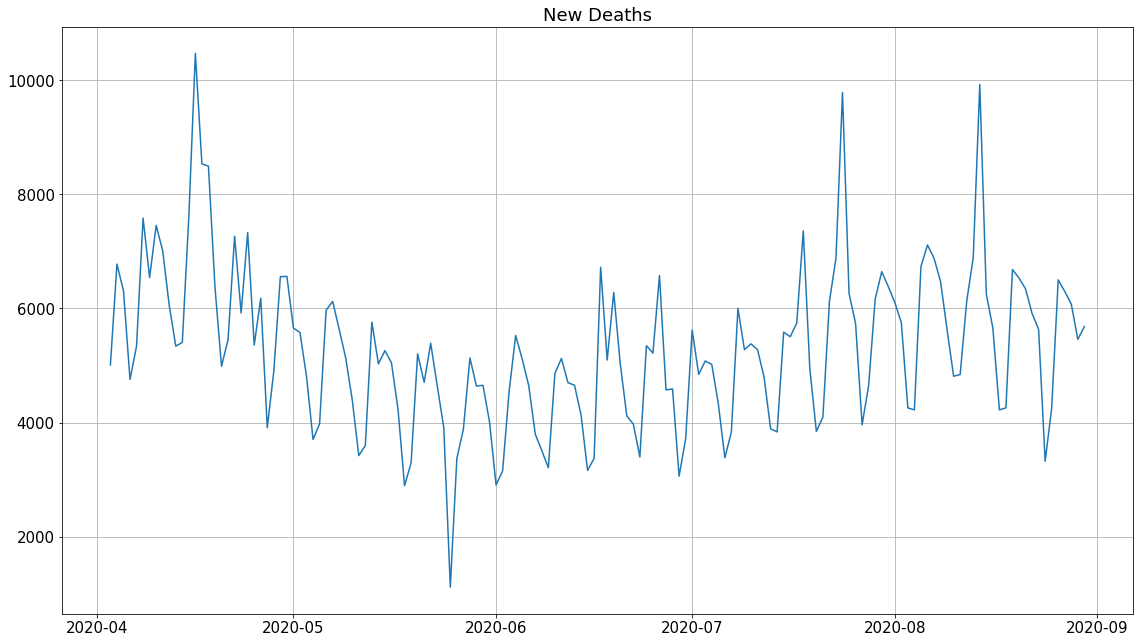

In [14]:
plt.figure(figsize=(19.20,10.80))
plt.plot(currency.new_deaths)
plt.title('New Deaths')
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [16]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

### $MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(currency, 7)

5369.285714285715

### $MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

In [31]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(19.20, 10.80))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "g--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

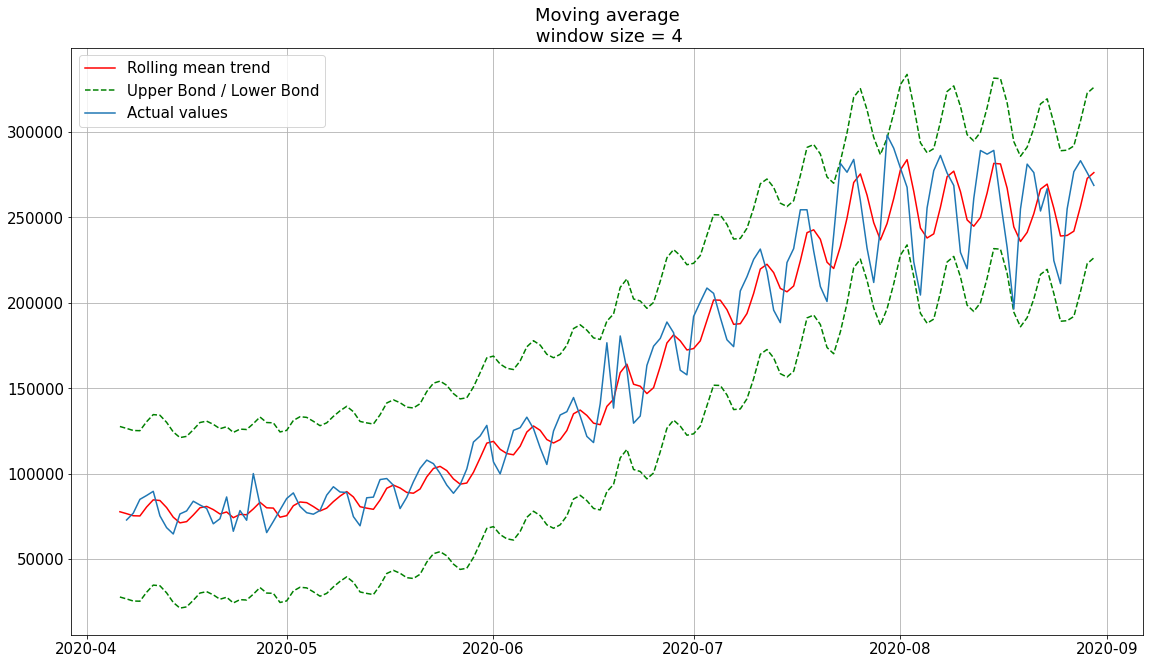

In [32]:
plotMovingAverage(ads, 4, plot_intervals=True)

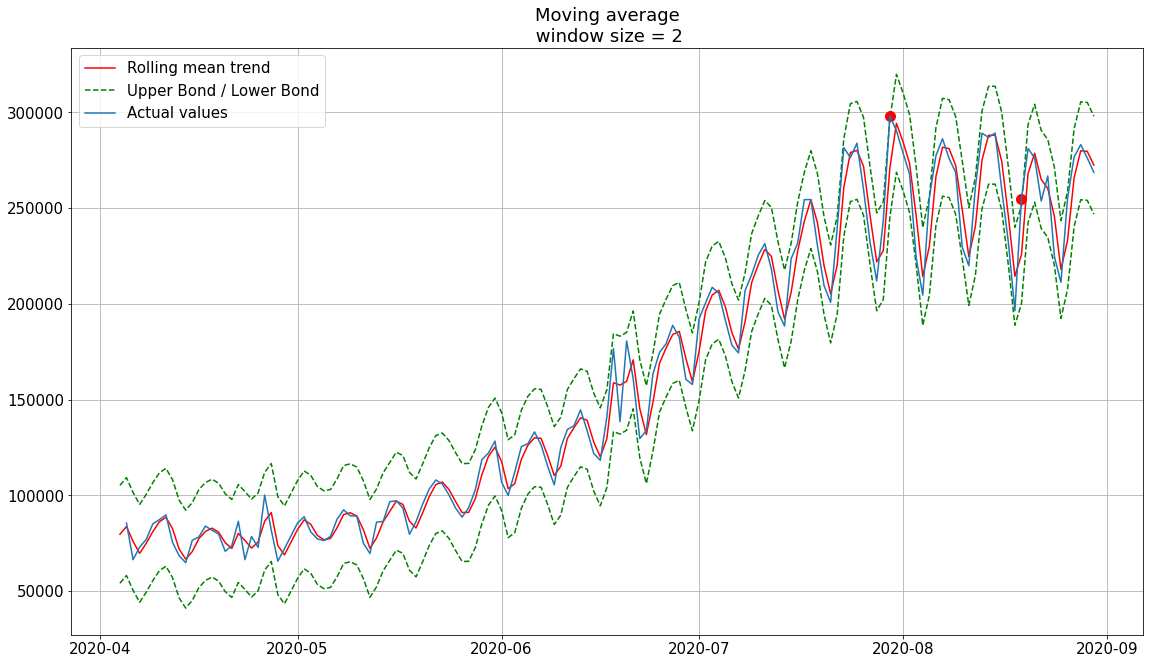

In [33]:
plotMovingAverage(ads, 2, plot_intervals=True, plot_anomalies=True)

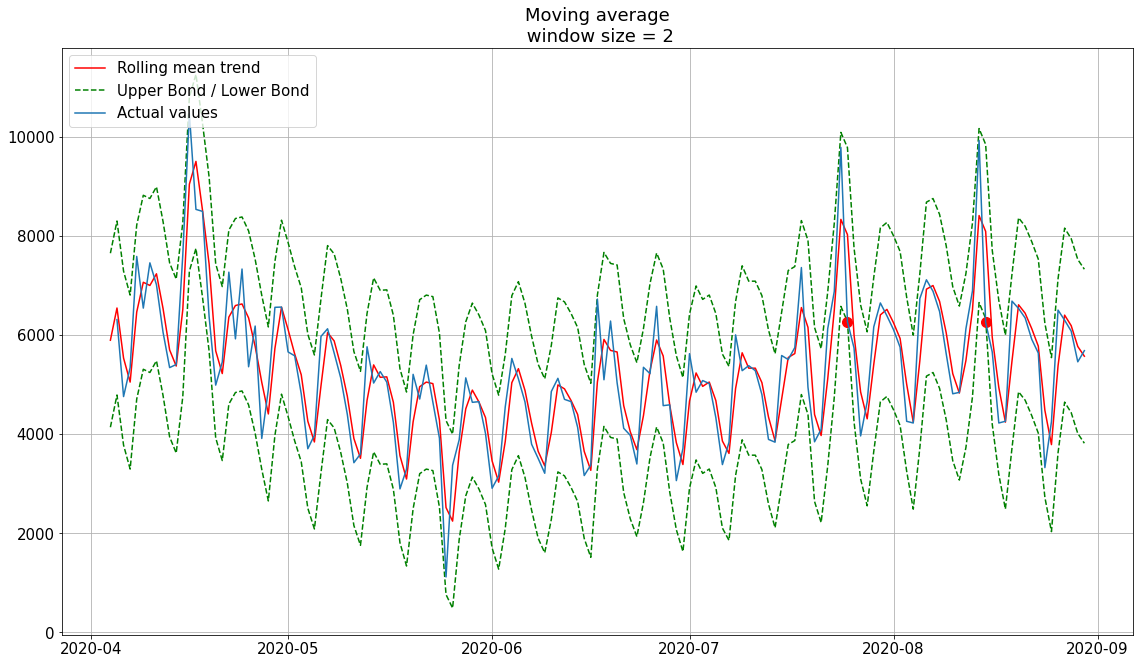

In [34]:
plotMovingAverage(currency, 2, plot_intervals=True, plot_anomalies=True)

### Weighted Average $\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$ 

In [36]:
def weighted_average(series, weights):
    result = 0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [39]:
weighted_average(ads, [0.6, 0.3, 0.1])

279591.8

In [46]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        
    return result

In [58]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(19.20,10.80))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
            
        plt.plot(series.values, 'r--', label='Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True)

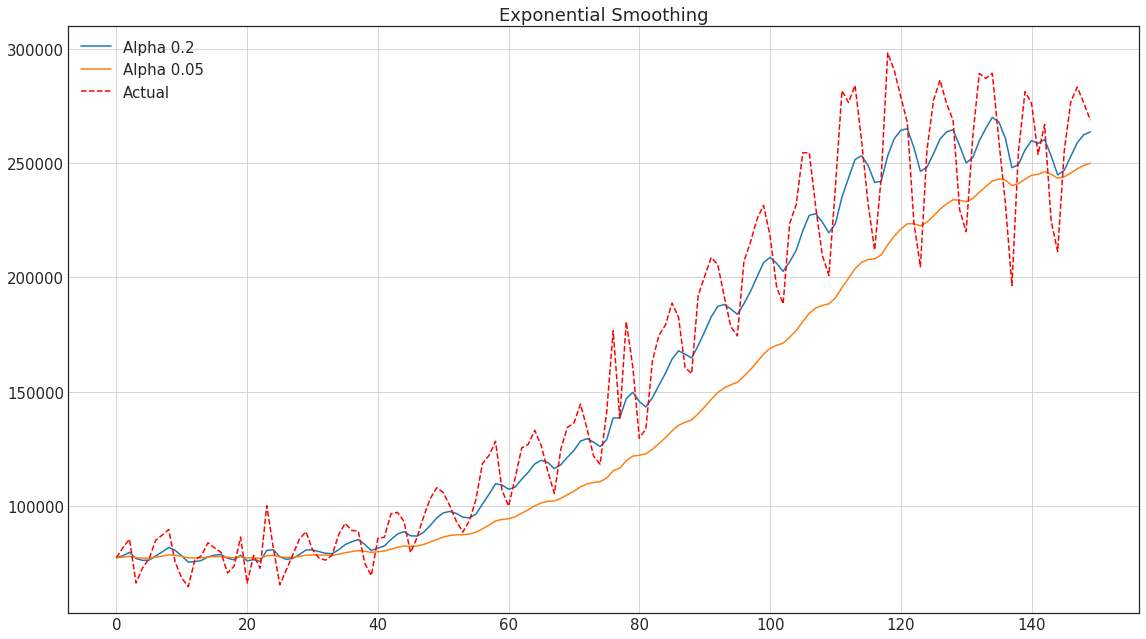

In [65]:
plotExponentialSmoothing(ads.new_cases, [0.2, 0.05])

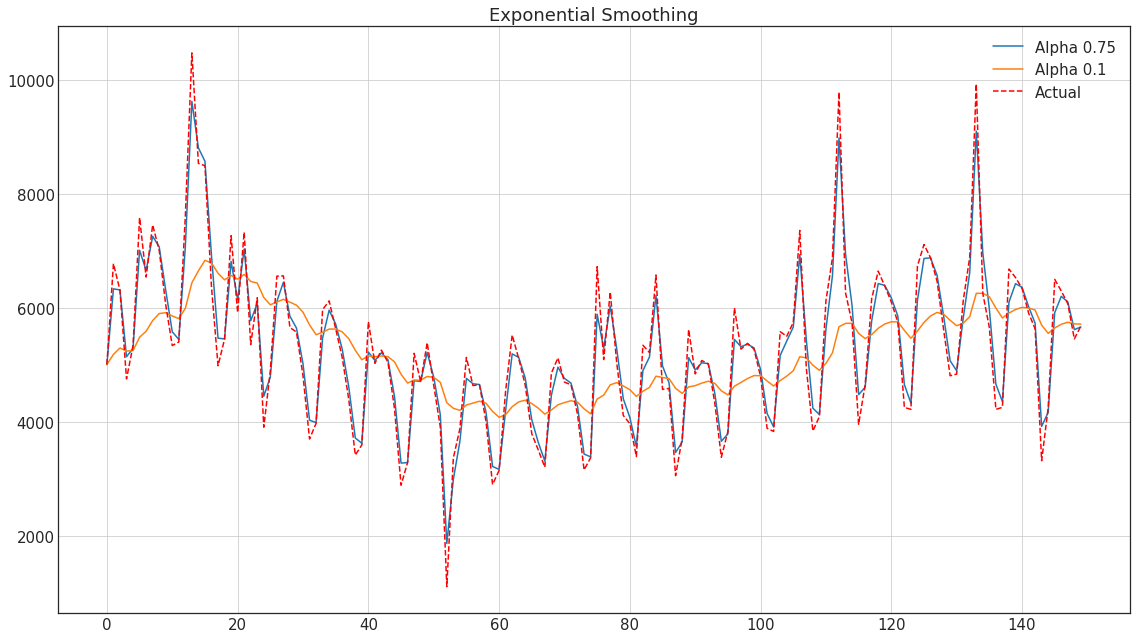

In [69]:
plotExponentialSmoothing(currency.new_deaths, [0.75, 0.1])

#### Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

#### Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python